In [17]:
import pandas as pd
import numpy as np
import os


# read txt file
def read_txt_file(file_path):
    """
    Reads a text file and returns its content as a pandas DataFrame.
    """
    try:
        df = pd.read_csv(file_path, sep=";", header=None)
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

data = read_txt_file('data/Rayonnement_global/dole.txt')    

In [18]:
# read the first 5 rows
print(data.head())

     0             1         2          3          4
0  stn          time  gre000z0  qgre000z0  mgre000z0
1  DOL  202301010000         0          4          -
2  DOL  202301010010         0          4          -
3  DOL  202301010020         0          4          -
4  DOL  202301010030         0          4          -


In [26]:
data.columns = ['stn', 'time', 'gre000z0', 'qgre000z0', 'mgre000z0']


In [31]:
# dort by desc ooder col gre000z0
data = data.sort_values(by='gre000z0', ascending=False)

In [32]:
# delete col where gre000z0 is 0
data = data[data['gre000z0'] != 0]

In [33]:
print(data)

        stn          time  gre000z0  qgre000z0  mgre000z0
0       stn          time  gre000z0  qgre000z0  mgre000z0
78267   DOL  202406271220       999          4          -
28724   DOL  202307191110       999          4          -
23393   DOL  202306121040       999          4          -
21681   DOL  202305311320       999          4          -
...     ...           ...       ...        ...        ...
7957    DOL  202302250600         0          4          -
7956    DOL  202302250550         0          4          -
7955    DOL  202302250540         0          4          -
7954    DOL  202302250530         0          4          -
118252  DOL  202504010430         0          4          -

[118253 rows x 5 columns]


In [36]:
# Ensure gre000z0 is numeric
data['gre000z0'] = pd.to_numeric(data['gre000z0'], errors='coerce')

# Function to get dates where gre000z0 is near zero
def get_near_zero_dates(df, threshold=7):
    """
    Returns the dates where gre000z0 is near to 0.
    """
    near_zero_dates = df[df['gre000z0'] < threshold]['time']
    return near_zero_dates

near_zero_dates = get_near_zero_dates(data)
print("Dates where gre000z0 is near to 0:")
print(near_zero_dates)

Dates where gre000z0 is near to 0:
71882     202405140410
71825     202405131840
117683    202503280540
72978     202405211850
114087    202503030620
              ...     
7957      202302250600
7956      202302250550
7955      202302250540
7954      202302250530
118252    202504010430
Name: time, Length: 61998, dtype: object


In [1]:
from netCDF4 import Dataset

# Open the file
ds = Dataset('data/inca/20230101.nc', mode='r')

# Print file format and global attributes
print("File format:", ds.file_format)
print("\nGlobal attributes:")
for attr in ds.ncattrs():
    print(f"  {attr}: {getattr(ds, attr)}")

# Print dimensions
print("\nDimensions:")
for dim in ds.dimensions.values():
    print(f"  {dim.name}: {len(dim)}")

# Print variables with shape, dimensions, and attributes
print("\nVariables:")
for var_name, var in ds.variables.items():
    print(f"  {var_name}: shape={var.shape}, dims={var.dimensions}")
    for attr in var.ncattrs():
        print(f"    - {attr}: {getattr(var, attr)}")
    # Optionally, print a small sample of data for 1D variables
    if var.ndim == 1:
        print(f"    - sample data: {var[:5]}")
for var_name, var in ds.variables.items():
    print(var_name, getattr(var, 'long_name', ''), getattr(var, 'standard_name', ''))
    
print("x:", ds.variables['x'][:5])
print("y:", ds.variables['y'][:5])

ds.close()

File format: NETCDF4

Global attributes:

Dimensions:
  x: 358
  y: 232
  datetime: 144

Variables:
  x: shape=(358,), dims=('x',)
    - _FillValue: nan
    - sample data: [476500. 477500. 478500. 479500. 480500.]
  y: shape=(232,), dims=('y',)
    - _FillValue: nan
    - sample data: [68500. 69500. 70500. 71500. 72500.]
  datetime: shape=(144,), dims=('datetime',)
    - units: minutes since 2023-01-01 00:00:00
    - calendar: proleptic_gregorian
    - sample data: [ 0 10 20 30 40]
  spatial_ref: shape=(), dims=()
    - crs_wkt: PROJCS["CH1903 / LV03",GEOGCS["CH1903",DATUM["CH1903",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6149"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4149"]],PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],PARAMETER["latitude_of_center",46.9524055555556],PARAMETER["longitude_of_center",7.43958333333333],PARAMETER["azimuth",90],PARA

## Variables description

- RR --> precipitation (mm/ h)
- TD -->  temperature at which air becomes fully saturated with moisture causing condense (degre)
- PT --> precipitation type (valeur de 0 à 5)
- WG --> coup de vent(m/s)
- TT --> temp à 2 mètre du sol(degres)
- TW --> ?
- CT --> couverture du ciel (%)
- FF --> wind speed(m/s)
- RS --> snowfall(mm/h)
- TG --> Temperature du surface du sol (deg)
- Z0 --> hauteur à la quelle il y le zero term.
- ZS --> hauteur à laquelle il y a la neige
- ZM --> ? 
- SU --> duré relative du soleil (%)
- DD --> direction du vent en dégré
For now for our analysis we can take RR,TD,WG,TT, CT, FF,RS,TG,(ZO), ZS, SU, DD + ! RAYONNEMENT GLOBAL given from IDAWWEB


In [4]:
import numpy as np
def find_lines_with_coordinates(file_path, x, y, tol=1000):
    """
    Finds and prints all variable values at positions where x and y coordinates match within tolerance.
    """
    ds = Dataset(file_path, mode='r')
    variable_names = ds.variables.keys()
    x_data = ds.variables['x'][:]
    y_data = ds.variables['y'][:]
    x_indices = np.where(np.abs(x_data - x) < tol)[0]
    y_indices = np.where(np.abs(y_data - y) < tol)[0]
    
    print(f"X indices: {x_indices}, Y indices: {y_indices}")
    for xi in x_indices:
        for yi in y_indices:
            print(f"\nValues at x index {xi} (x={x_data[xi]}), y index {yi} (y={y_data[yi]}):")
            for var in variable_names:
                var_obj = ds.variables[var]
                if var_obj.ndim == 2:
                    print(f"{var}: {var_obj[yi, xi]}")
    # pritn 
    ds.close()

find_lines_with_coordinates('data/inca/20230101.nc', 497035., 142375.)

X indices: [20 21], Y indices: [73 74]

Values at x index 20 (x=496500.0), y index 73 (y=141500.0):

Values at x index 20 (x=496500.0), y index 74 (y=142500.0):

Values at x index 21 (x=497500.0), y index 73 (y=141500.0):

Values at x index 21 (x=497500.0), y index 74 (y=142500.0):


In [5]:
from pyproj import Transformer
transformer = Transformer.from_crs("4326", "21781")

In [6]:
a = transformer.transform(46.38318, 6.23955)  # nyon



In [7]:
print(a)

(507755.9989529766, 137574.4543006527)


In [ ]:
from pyproj import Transformer
from netCDF4 import Dataset, num2date
import numpy as np

# Step 1: Convert latitude/longitude to CH1903 / LV03
lat, lon = 46.424797, 6.099136  # Dole coordinates
transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781")
easting, northing = transformer.transform(lat, lon)

print(f"Converted coords: Easting={easting}, Northing={northing}")

# Step 2: Open NetCDF file
nc_path = "data/inca/20230627.nc"  # <-- replace with your actual path
nc = Dataset(nc_path)

# Step 3: Read grid coordinate arrays
x_vals = nc.variables['x'][:]  # shape: (358,)
y_vals = nc.variables['y'][:]  # shape: (232,)

# Step 4: Find closest grid indices
ix = np.argmin(np.abs(x_vals - easting))
iy = np.argmin(np.abs(y_vals - northing))

print(f"Closest grid index -> x: {ix}, y: {iy}")

# Step 5: Read temperature value at time=0
TT = nc.variables['TT']  # or 'TT_ext', depending on what's available
index = 70
temperature = TT[index, iy, ix]  # assuming dimensions are (time, y, x)
# print time
time_var = nc.variables['datetime']

# Get the units from the variable object, not the array
dt0 = num2date(time_var[index], units=time_var.units)
print("Time 0 as datetime:", dt0)

print(f"Temperature at location: {temperature:.2f} °C")


Converted coords: Easting=507755.9989529766, Northing=137574.4543006527
Closest grid index -> x: 31, y: 69
Time 0 as datetime: 2023-06-27 11:40:00
Temperature at location: 24.45 °C


In [17]:
from netCDF4 import Dataset, num2date

nc = Dataset("data/inca/20230101.nc")
time_var = nc.variables['datetime']

# Get the units from the variable object, not the array
print("Time variable units:", time_var.units)

# Convert the first time value to a datetime object
dt0 = num2date(time_var[0], units=time_var.units)
print("Time 0 as datetime:", dt0)
print("Hour of time 0:", dt0.hour)

nc.close()

Time variable units: minutes since 2023-01-01 00:00:00
Time 0 as datetime: 2023-01-01 00:00:00
Hour of time 0: 0


In [39]:
from pyproj import Transformer
from netCDF4 import Dataset, num2date
import numpy as np

# Define your points (lat, lon)
points = {
    "nyon": (46.38318, 6.23955),
    "dole": (46.424797, 6.099136)
}

# Open NetCDF file
nc_path = "data/inca/20230627.nc"
nc = Dataset(nc_path)

x_vals = nc.variables['x'][:]
y_vals = nc.variables['y'][:]

# Prepare transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781")

# Extract and convert datetime variable
time_var = nc.variables['datetime']
datetimes = num2date(time_var[:], units=time_var.units)
# Optionally, convert to strings for easier saving/loading
datetimes_str = np.array([dt.isoformat() for dt in datetimes])

# Prepare dictionary to store results
results = {}

for name, (lat, lon) in points.items():
    easting, northing = transformer.transform(lat, lon)
    ix = np.argmin(np.abs(x_vals - easting))
    iy = np.argmin(np.abs(y_vals - northing))
    print(f"{name}: grid index x={ix}, y={iy} (E={easting}, N={northing})")
    
    # Extract all time steps for this point for all 3D variables (time, y, x)
    point_data = {}
    for var_name, var in nc.variables.items():
        if var_name in ['RR', 'TD', 'WG', 'TT', 'CT', 'FF', 'RS', 'TG', 'Z0', 'ZS', 'SU', 'DD']:
            if var.ndim == 3 and var.shape[1:] == (len(y_vals), len(x_vals)):
                point_data[var_name] = var[:, iy, ix]
    # Add datetime array to each point's data
    point_data['datetime'] = datetimes_str
    results[name] = point_data

# Save to compressed npz
np.savez_compressed("nyon_dole_data.npz", **results)

nc.close()

nyon: grid index x=31, y=69 (E=507755.9989529766, N=137574.4543006527)
dole: grid index x=21, y=74 (E=497034.3019121836, N=142375.13761311217)


In [42]:
data = np.load("nyon_dole_data.npz", allow_pickle=True)
print(data.files)
print(data['nyon'].item().keys())  # .item() to get the dict if you saved dicts
print(len(data['nyon'].item()['datetime']))  # Access the datetime array
print(data['nyon'].item()['TT'])  # Access the TT array

['nyon', 'dole']
dict_keys(['TD', 'WG', 'TT', 'CT', 'FF', 'RS', 'TG', 'Z0', 'ZS', 'SU', 'DD', 'RR', 'datetime'])
144
[19.8107967376709 19.5162353515625 18.87763786315918 18.959692001342773
 19.07773780822754 18.8730525970459 19.17763328552246 18.591981887817383
 18.034292221069336 18.31831169128418 17.923938751220703
 17.333070755004883 17.73780632019043 17.21986198425293 16.595964431762695
 17.24314308166504 16.65761947631836 16.86425018310547 16.98934555053711
 17.207372665405273 17.444351196289062 17.56085777282715 17.58843231201172
 17.42786407470703 17.384693145751953 16.593820571899414 17.03338623046875
 17.42767333984375 17.60179901123047 17.325952529907227 17.356414794921875
 17.510225296020508 17.870546340942383 18.307214736938477
 18.370485305786133 18.5875301361084 18.82841682434082 18.57916831970215
 18.50898551940918 18.427597045898438 18.98885726928711 19.271011352539062
 19.402498245239258 19.758962631225586 19.388595581054688
 19.85824203491211 20.445568084716797 20.669

# Stratus condition

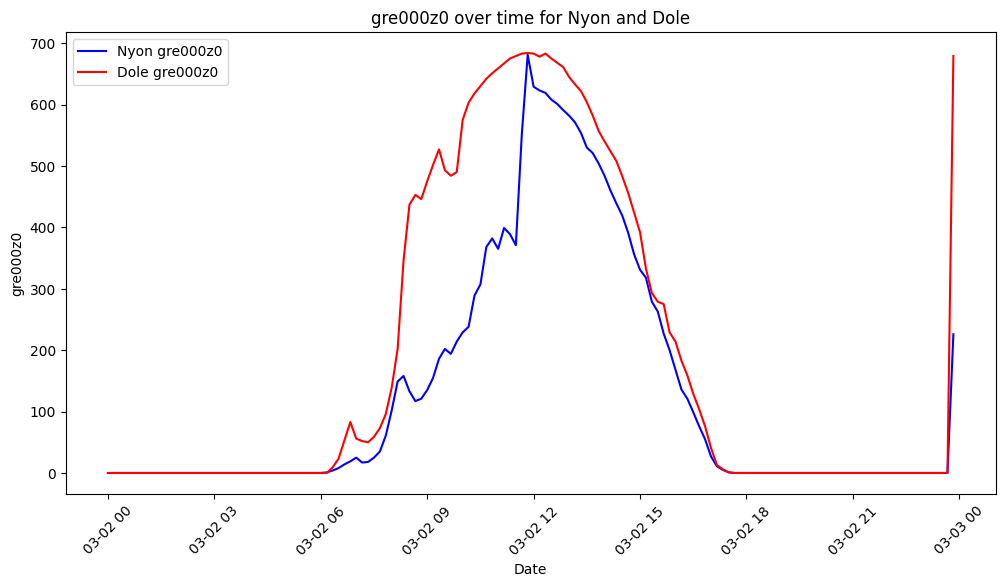

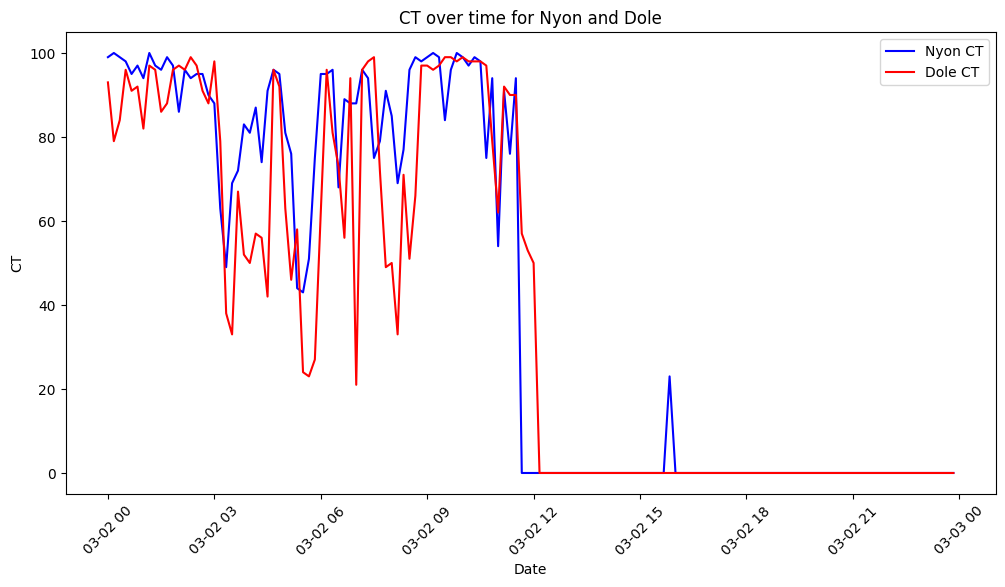

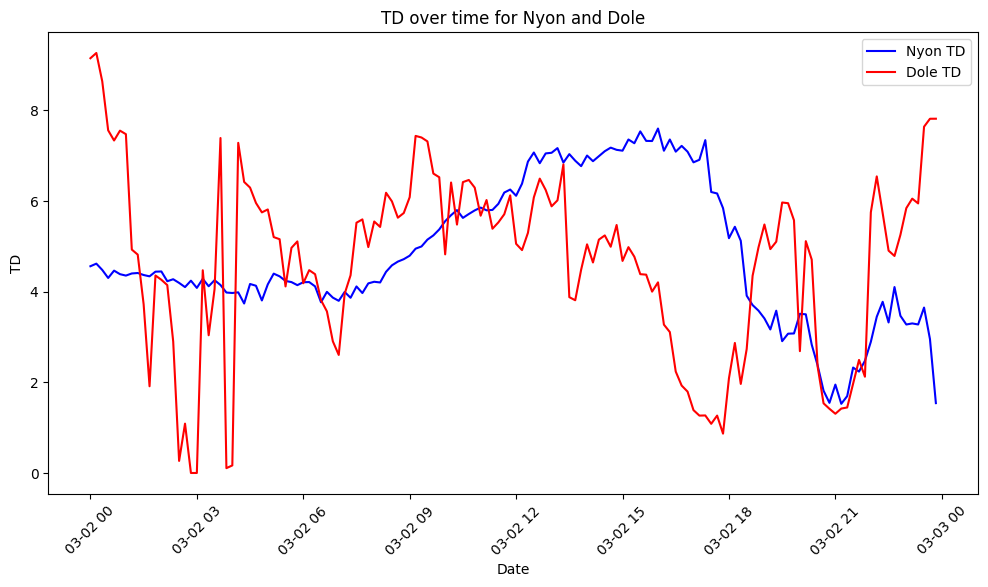

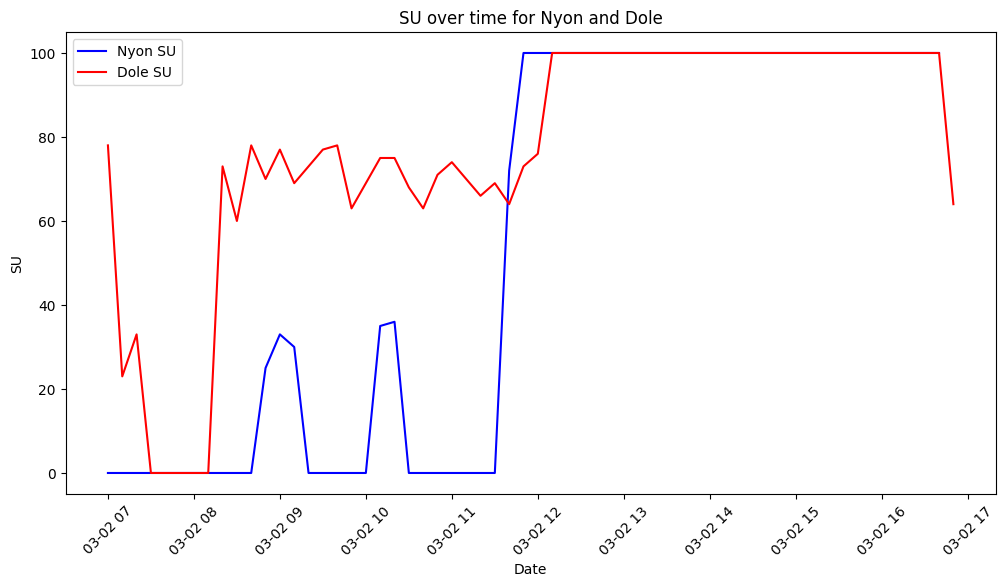

In [19]:
# Plotting stratus condition of 20230203
import matplotlib.pyplot as plt
import numpy as np
# read  idaweb_data.npz
date = "2023-03-02"
data = np.load("idaweb_data.npz", allow_pickle=True)
nyon_data = data['nyon'].item()
dole_data = data['dole'].item()
# Get the datetime array
nyon_datetime = nyon_data['datetime']
dole_datetime = dole_data['datetime']
# Get the gre000z0 array
nyon_gre000z0 = nyon_data['gre000z0']
dole_gre000z0 = dole_data['gre000z0']
# filter datetime array for day 20230302
# get ct for 20230302 for nyon and dole
nyon_ct = nyon_data['CT']
dole_ct = dole_data['CT']
# For CT
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_ct = nyon_data['CT'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_ct = dole_data['CT'][dole_mask]

# For nyon
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_gre000z0 = nyon_data['gre000z0'][nyon_mask]

# For dole
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_gre000z0 = dole_data['gre000z0'][dole_mask]

# Convert datetime strings to datetime objects
from datetime import datetime
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_gre000z0, label='Nyon gre000z0', color='blue')
plt.plot(dole_datetime, dole_gre000z0, label='Dole gre000z0', color='red')

plt.xlabel('Date')
plt.ylabel('gre000z0')
plt.title('gre000z0 over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
# plot on anther graph CT values
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_ct, label='Nyon CT', color='blue')
plt.plot(dole_datetime, dole_ct, label='Dole CT', color='red')
plt.xlabel('Date')
plt.ylabel('CT')
plt.title('CT over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()

# search and plot td valuues of dole and nyon
# For TD
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_td =nyon_data['TT'][nyon_mask]- nyon_data['TD'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_td = dole_data['TT'][dole_mask]-dole_data['TD'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_td, label='Nyon TD', color='blue')
plt.plot(dole_datetime, dole_td, label='Dole TD', color='red')
plt.xlabel('Date')
plt.ylabel('TD')
plt.title('TD over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()

# FOR SU
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_su = nyon_data['SU'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_su = dole_data['SU'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_su, label='Nyon SU', color='blue')
plt.plot(dole_datetime, dole_su, label='Dole SU', color='red')
plt.xlabel('Date')
plt.ylabel('SU')
plt.title('SU over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()


 # Half stratus condition

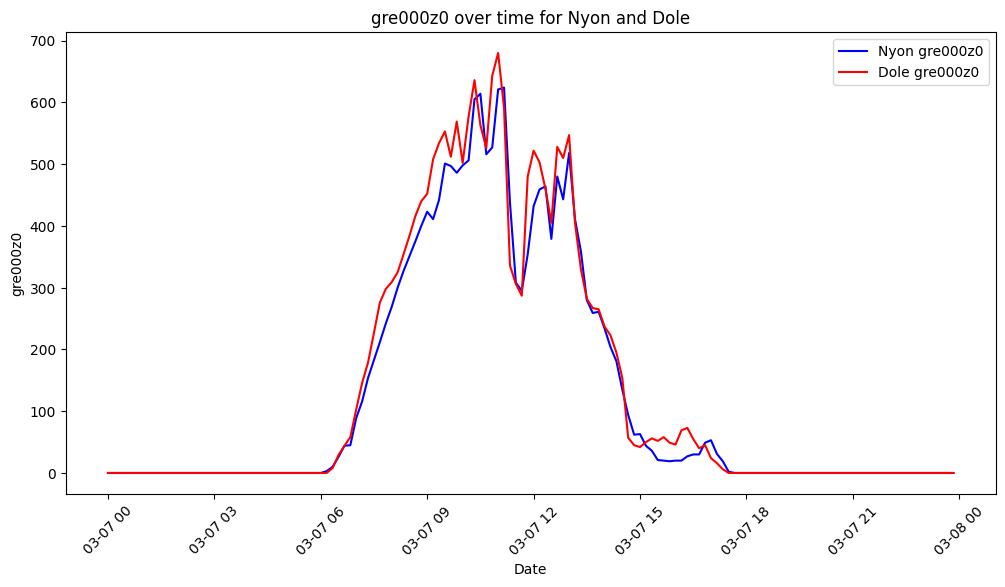

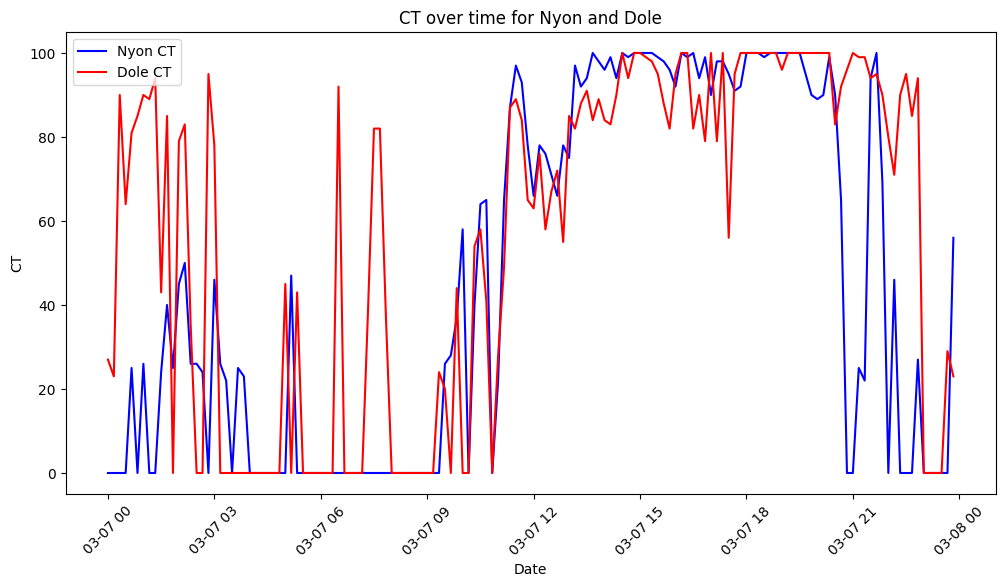

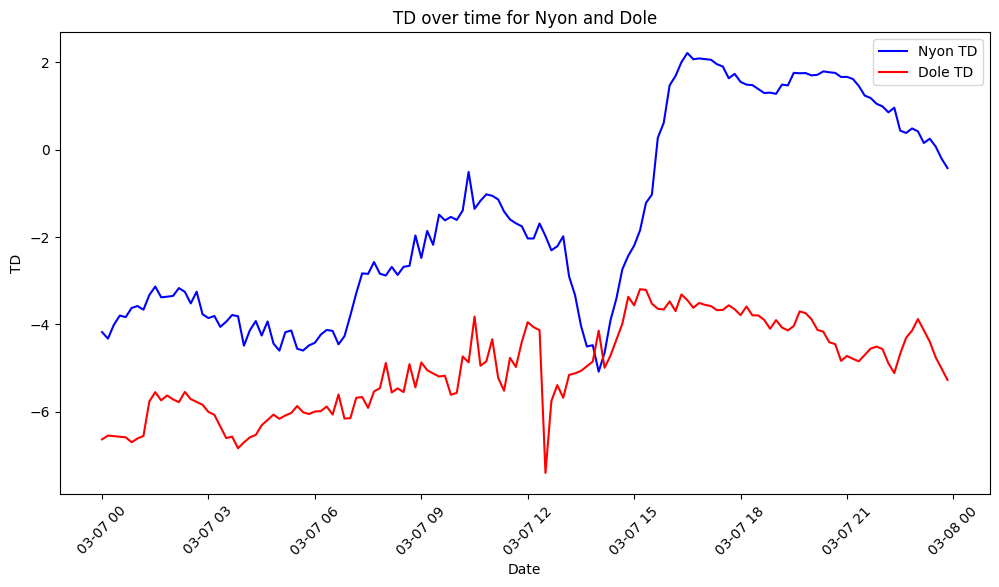

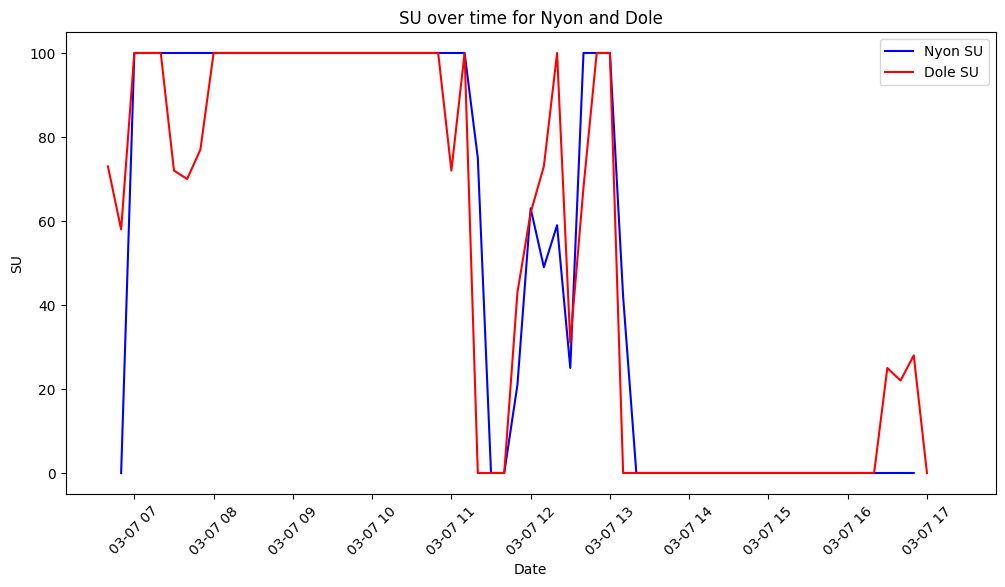

In [23]:
# Plotting stratus condition of 20230203
import matplotlib.pyplot as plt
import numpy as np
# read  idaweb_data.npz
date = "2023-03-07"
data = np.load("idaweb_data.npz", allow_pickle=True)
nyon_data = data['nyon'].item()
dole_data = data['dole'].item()
# Get the datetime array
nyon_datetime = nyon_data['datetime']
dole_datetime = dole_data['datetime']
# Get the gre000z0 array
nyon_gre000z0 = nyon_data['gre000z0']
dole_gre000z0 = dole_data['gre000z0']
# filter datetime array for day 20230302
# get ct for 20230302 for nyon and dole
nyon_ct = nyon_data['CT']
dole_ct = dole_data['CT']
# For CT
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_ct = nyon_data['CT'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_ct = dole_data['CT'][dole_mask]

# For nyon
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_gre000z0 = nyon_data['gre000z0'][nyon_mask]

# For dole
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_gre000z0 = dole_data['gre000z0'][dole_mask]

# Convert datetime strings to datetime objects
from datetime import datetime
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_gre000z0, label='Nyon gre000z0', color='blue')
plt.plot(dole_datetime, dole_gre000z0, label='Dole gre000z0', color='red')

plt.xlabel('Date')
plt.ylabel('gre000z0')
plt.title('gre000z0 over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
# plot on anther graph CT values
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_ct, label='Nyon CT', color='blue')
plt.plot(dole_datetime, dole_ct, label='Dole CT', color='red')
plt.xlabel('Date')
plt.ylabel('CT')
plt.title('CT over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()

# search and plot td valuues of dole and nyon
# For TD
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_td = nyon_data['TD'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_td = dole_data['TD'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_td, label='Nyon TD', color='blue')
plt.plot(dole_datetime, dole_td, label='Dole TD', color='red')
plt.xlabel('Date')
plt.ylabel('TD')
plt.title('TD over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
# FOR SU
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_su = nyon_data['SU'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_su = dole_data['SU'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_su, label='Nyon SU', color='blue')
plt.plot(dole_datetime, dole_su, label='Dole SU', color='red')
plt.xlabel('Date')
plt.ylabel('SU')
plt.title('SU over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()


# Sunny condition

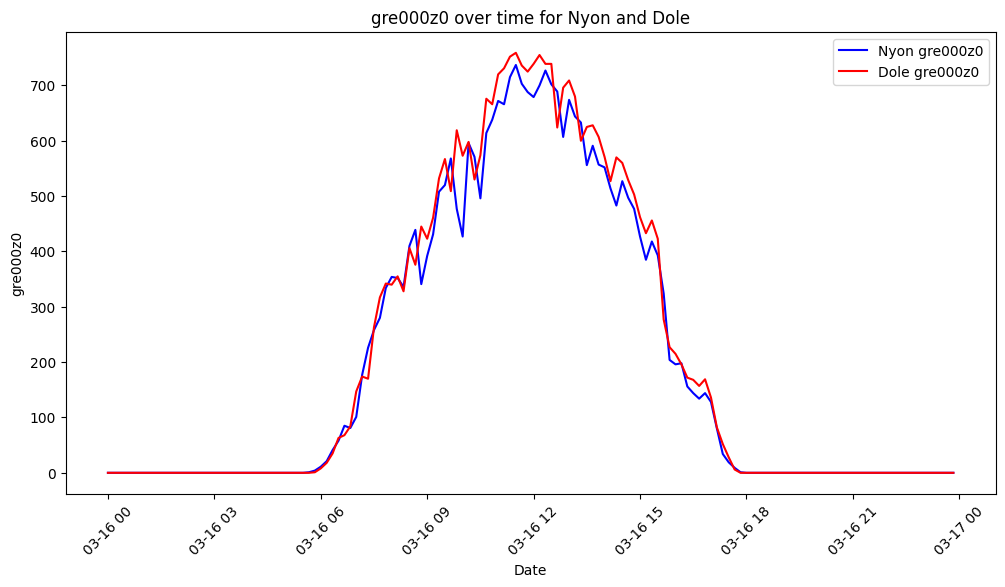

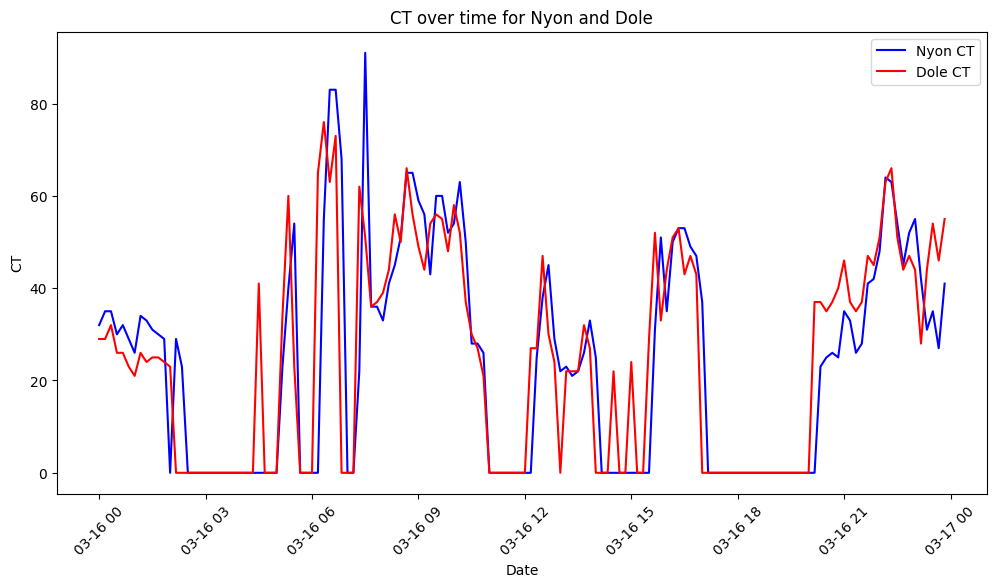

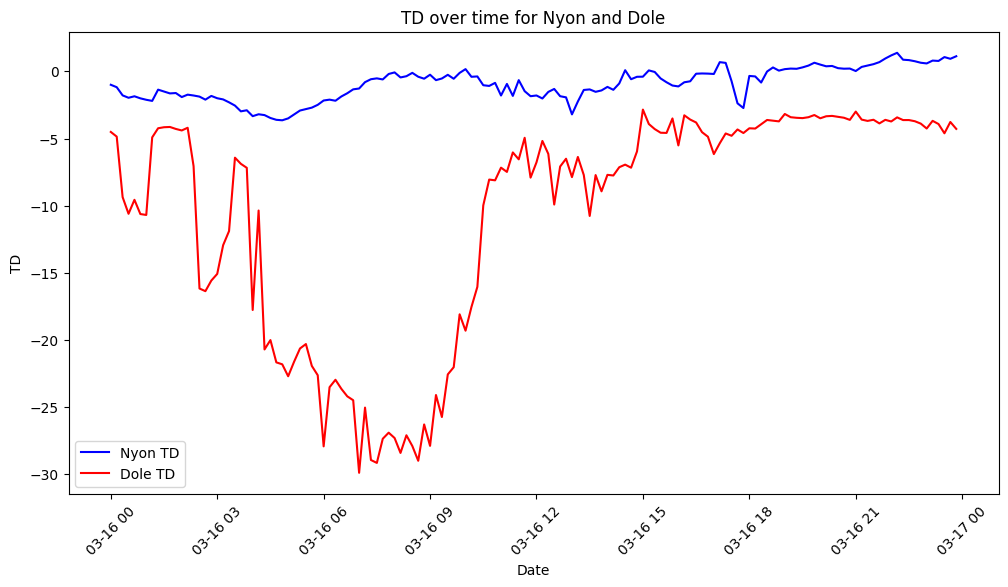

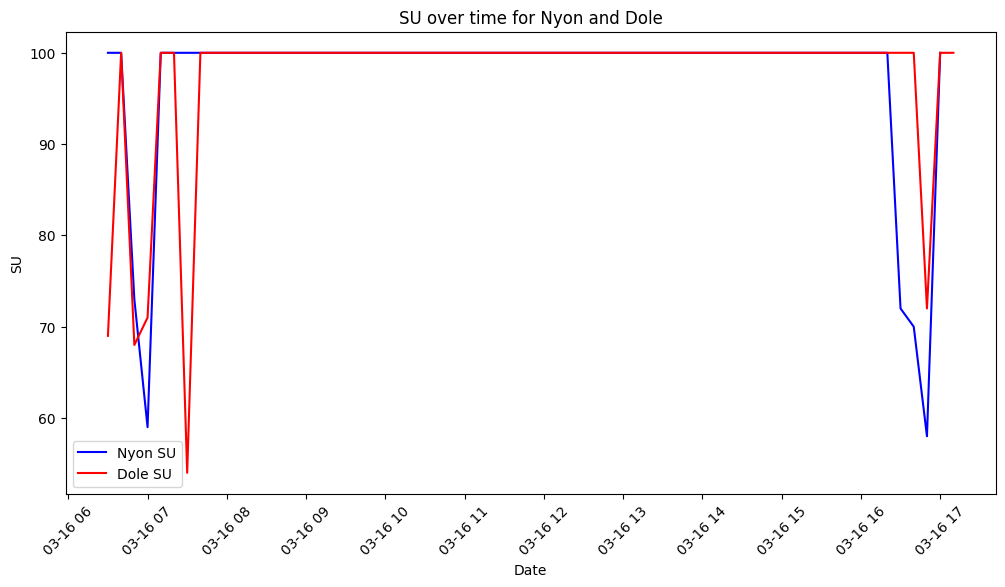

In [21]:
# Plotting stratus condition of 20230203
import matplotlib.pyplot as plt
import numpy as np
# read  idaweb_data.npz
date = "2023-03-16"
data = np.load("idaweb_data.npz", allow_pickle=True)
nyon_data = data['nyon'].item()
dole_data = data['dole'].item()
# Get the datetime array
nyon_datetime = nyon_data['datetime']
dole_datetime = dole_data['datetime']
# Get the gre000z0 array
nyon_gre000z0 = nyon_data['gre000z0']
dole_gre000z0 = dole_data['gre000z0']
# filter datetime array for day 20230302
# get ct for 20230302 for nyon and dole
nyon_ct = nyon_data['CT']
dole_ct = dole_data['CT']
# For CT
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_ct = nyon_data['CT'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_ct = dole_data['CT'][dole_mask]

# For nyon
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_gre000z0 = nyon_data['gre000z0'][nyon_mask]

# For dole
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_gre000z0 = dole_data['gre000z0'][dole_mask]

# Convert datetime strings to datetime objects
from datetime import datetime
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_gre000z0, label='Nyon gre000z0', color='blue')
plt.plot(dole_datetime, dole_gre000z0, label='Dole gre000z0', color='red')

plt.xlabel('Date')
plt.ylabel('gre000z0')
plt.title('gre000z0 over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
# plot on anther graph CT values
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_ct, label='Nyon CT', color='blue')
plt.plot(dole_datetime, dole_ct, label='Dole CT', color='red')
plt.xlabel('Date')
plt.ylabel('CT')
plt.title('CT over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()

# search and plot td valuues of dole and nyon
# For TD
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_td = nyon_data['TD'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_td = dole_data['TD'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_td, label='Nyon TD', color='blue')
plt.plot(dole_datetime, dole_td, label='Dole TD', color='red')
plt.xlabel('Date')
plt.ylabel('TD')
plt.title('TD over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
# FOR SU
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_su = nyon_data['SU'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_su = dole_data['SU'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_su, label='Nyon SU', color='blue')
plt.plot(dole_datetime, dole_su, label='Dole SU', color='red')
plt.xlabel('Date')
plt.ylabel('SU')
plt.title('SU over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
